## XGBoost

Random Forests take the majority or average result of independent estimators (decision trees).

Boosting is another method of combining multiple decision trees. With boosting, we work sequentially with multiple models. After each model has been built, we look at the errors this model is making and use this knowledge to train the next model, attempting to reduce these errors.

We sequentially train models and each model attempts to correct the mistakes of its predecessor. Each model will produce predictions and our final prediction is based on the average of majority result of all the estimators.

XGBoost is a type of boosting where each model is a decision tree.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm.auto import tqdm

In [3]:
df_collision = pd.read_csv("../1_eda/data/collisions_final.csv")
df_collision.head(2)

,police_force,number_of_vehicles,day_of_week,time,first_road_class,road_type,speed_limit,light_conditions,weather_conditions,road_surface_conditions,is_severe,month,day_of_year,is_trunk,is_near_pedestrian_crossing,is_urban,has_special_conditions_at_site,is_carriageway_hazard,is_near_junction
0,metropolitan_police,1,sunday,01:00,c,one_way_street,20,darkness___lights_lit,other_adverse_weather_condition,wet_or_damp,0,january,1,0,1,1,0,0,1
1,metropolitan_police,3,sunday,02:00,unclassified,single_carriageway,30,darkness___lights_lit,fine_no_high_winds,dry,0,january,1,0,1,1,0,0,1


## Prepare data


In [4]:
df_full_train, df_test = train_test_split(df_collision, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["is_severe"].values
y_val = df_val["is_severe"].values
y_test = df_test["is_severe"].values

del df_train["is_severe"]
del df_val["is_severe"]
del df_test["is_severe"]

In [5]:
x_train_dicts = df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False).fit(x_train_dicts)
X_train = dv.transform(x_train_dicts)
# additional transforming for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dv.get_feature_names_out()))

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)
# additional transforming for XGBoost
dval = xgb.DMatrix(X_val, label=y_val, feature_names = list(dv.get_feature_names_out()))

## Base model

We will train an initial XGBoost model using the defaults and then later tune some of these parameters to try and improve the model.

### Background on XGBoost parameters

XGBoost has three sets of parameters

1. general parameters: the key one to set here is the type of booster.
   
- `booster`: type of booster. We will use the default `gbtree` (a booster using tree based models)


2.. booster parameters: these are specific to the booster chosen. For our tree booster, we will look at

- `eta`: this is the learning rate i.e. how fast our model learns, range: [0,1]
  
- `max_depth`: similar to RandomForest, this is the max depth of the tree. Increasing the depth makes the model more complex with the added danger of it overfitting, range: [0,∞]


  
- `min_child_weight`: similar to `min_samples_leaf`, range: [0,∞]

3. learning task parameters: here is when you decide on the learning scenario.

- `objective`: what type of learning are you doing. We are performing a binary classification i.e. `binary:logistic`
  
- `eval_metric`: how do you want the model to be evaluated e.g. you could evaluate with root mean squared error, roc_auc_score. We will stick with the latter, which is `auc`.

In [6]:
num_boost_round = 10 # default

xgb_params = {
    'booster': 'gbtree', # default
    'verbosity': 1, # default
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': 0.3, # default
    'max_depth': 6, # default,
    'min_child_weight': 1, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round)

y_pred = model.predict(dval)

roc_auc_score(y_val, y_pred)

np.float64(0.622532338315994)

**Observations**

`roc_auc_score`: Our base random forest model has an `roc_auc_score` of around 0.623. Given that our RandomForest model's score was 0.628 after tuning, this is not a bad start.

## Model Tuning

### How many boosting iterations should we have? (num_boost_round)

Boosting works by iterating on the results of previous decision trees. The more rounds we have, the less error but we do increase our risk of overfitting.

**Note on evaluation**

When tuning other models, we calculated the `roc_auc_score` manually. We can get XGBoost's evaluation after each iteration by passing in a watchlist to `evals`. This is a list of datasets that you want to evaluate at each iteration. We want the training and validation sets to be tested.

In the lectures we printed the results to the console but I found that I could capture the results using an `evals_result` parameter. See [XGBoost docs example](https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html)

**Approach**

I follow the approach in the lectures and run 200 rounds with XGBoost outputting the results after every round in order to get a sense of how many iterations are optimal.

All the other parameters remain as default.

In [7]:
watchlist = [(dtrain, "train"), (dval, "val")]

def train_and_evaluate(xgb_p, num_boost_round=10):
    """Train and evaluate a Gradient Boost model with provided parameters
    
    Returns
    -------
    pd.DataFrame with auc_scores for training and validation datasets after every iteration
    """
    evals_results = {}
    model = xgb.train(xgb_p, dtrain, num_boost_round=num_boost_round, evals=watchlist, evals_result=evals_results)

    train_results = evals_results["train"]["auc"]
    val_results = evals_results["val"]["auc"]
    n_iter = range(0,num_boost_round)
    df_results = pd.DataFrame({"num_iter": n_iter, "train_auc": train_results, "val_auc": val_results})  
    return df_results

In [12]:
num_boost_round = 200

xgb_params = {
    'booster': 'gbtree', # default
    'verbosity': 0, # turn off logs
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': 0.3, # default
    'max_depth': 6, # default,
    'min_child_weight': 1, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

df_scores = train_and_evaluate(xgb_params, num_boost_round)
df_scores.sort_values(by="val_auc", ascending=False)

[0]	train-auc:0.60997	val-auc:0.59872
[1]	train-auc:0.61965	val-auc:0.60998
[2]	train-auc:0.62482	val-auc:0.61141
[3]	train-auc:0.63256	val-auc:0.61663
[4]	train-auc:0.63755	val-auc:0.61864
[5]	train-auc:0.64252	val-auc:0.61902
[6]	train-auc:0.64612	val-auc:0.61981
[7]	train-auc:0.65243	val-auc:0.62157
[8]	train-auc:0.65773	val-auc:0.62205
[9]	train-auc:0.66062	val-auc:0.62253
[10]	train-auc:0.66367	val-auc:0.62199
[11]	train-auc:0.66810	val-auc:0.62246
[12]	train-auc:0.67142	val-auc:0.62378
[13]	train-auc:0.67298	val-auc:0.62341
[14]	train-auc:0.67602	val-auc:0.62312
[15]	train-auc:0.67926	val-auc:0.62340
[16]	train-auc:0.68258	val-auc:0.62404
[17]	train-auc:0.68500	val-auc:0.62471
[18]	train-auc:0.68695	val-auc:0.62480
[19]	train-auc:0.68943	val-auc:0.62552
[20]	train-auc:0.69168	val-auc:0.62565
[21]	train-auc:0.69278	val-auc:0.62508
[22]	train-auc:0.69499	val-auc:0.62468
[23]	train-auc:0.69733	val-auc:0.62489
[24]	train-auc:0.69869	val-auc:0.62461
[25]	train-auc:0.70019	val-auc:0.62

,num_iter,train_auc,val_auc
20,20,0.691684,0.625653
19,19,0.689430,0.625519
21,21,0.692776,0.625081
23,23,0.697335,0.624893
18,18,0.686948,0.624800
...,...,...,...
196,196,0.846193,0.600891
197,197,0.846315,0.600720
198,198,0.846715,0.600649
199,199,0.847232,0.600598


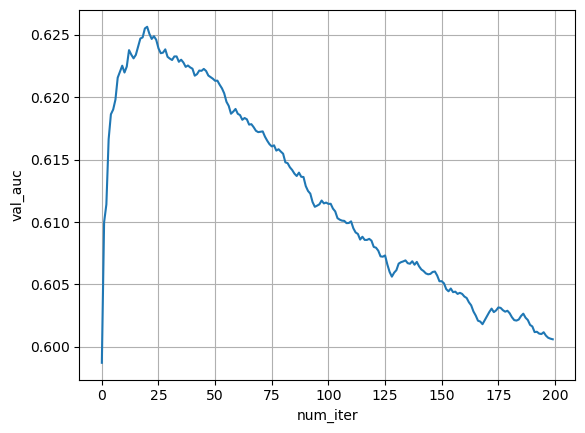

In [13]:
sns.lineplot(data=df_scores, x="num_iter", y="val_auc")
plt.grid()
plt.show()

**Conclusion**

We can see that we hit our peak performance in the validation set at 20 iterations where the validation auc score is 	0.625653. After this performance diminishes.

It's worth noting that we are using the default learning rate here, which is 0.3. 0.3 is quite a high learning rate and there is a relationship between the number of boosting rounds and the learning rate. It's possible that a lower learning rate might require more iterations but actually produce a better result. In this sense, we can't really identify the optimal number of iterations yet.

### What's the ideal learning rate?

The default learning rate (0.3) is quite high. We will look at a range.

In [14]:
num_boost_round = 200

eta_test_values = [0.01,0.05,0.08,0.1,0.2,0.3,1]

scores_eta = {}

for learning_rate in tqdm(eta_test_values):
    xgb_params = {
        'booster': 'gbtree', # default
        'verbosity': 0, # turn off logs
        'nthread': 6, # how many cores/ how much parallelization, depends on your system
    
        'eta': learning_rate, 
        'max_depth': 6, # default,
        'min_child_weight': 1, # default
    
        'objective' :'binary:logistic', 
        'seed': 1, # random number seed to make the results reproducible
        'eval_metric': 'auc'
    }

    key = f'eta={learning_rate}'
    scores_eta[key] = train_and_evaluate(xgb_params, num_boost_round)

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-auc:0.60997	val-auc:0.59872
[1]	train-auc:0.61001	val-auc:0.59864
[2]	train-auc:0.61100	val-auc:0.60166
[3]	train-auc:0.61185	val-auc:0.60087
[4]	train-auc:0.61160	val-auc:0.60173
[5]	train-auc:0.61190	val-auc:0.60240
[6]	train-auc:0.61300	val-auc:0.60361
[7]	train-auc:0.61313	val-auc:0.60387
[8]	train-auc:0.61314	val-auc:0.60377
[9]	train-auc:0.61333	val-auc:0.60399
[10]	train-auc:0.61373	val-auc:0.60397
[11]	train-auc:0.61385	val-auc:0.60392
[12]	train-auc:0.61398	val-auc:0.60421
[13]	train-auc:0.61400	val-auc:0.60411
[14]	train-auc:0.61467	val-auc:0.60517
[15]	train-auc:0.61501	val-auc:0.60536
[16]	train-auc:0.61505	val-auc:0.60536
[17]	train-auc:0.61572	val-auc:0.60625
[18]	train-auc:0.61583	val-auc:0.60662
[19]	train-auc:0.61626	val-auc:0.60742
[20]	train-auc:0.61814	val-auc:0.60838
[21]	train-auc:0.61802	val-auc:0.60842
[22]	train-auc:0.61851	val-auc:0.60956
[23]	train-auc:0.61831	val-auc:0.60957
[24]	train-auc:0.61801	val-auc:0.60969
[25]	train-auc:0.61884	val-auc:0.60

In [15]:
scores_eta.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.08', 'eta=0.1', 'eta=0.2', 'eta=0.3', 'eta=1'])

In [21]:
scores_eta['eta=0.1'].sort_values(by="val_auc", ascending=False).head(4)

,num_iter,train_auc,val_auc
48,48,0.680429,0.628275
49,49,0.681116,0.628228
35,35,0.668230,0.628138
39,39,0.671862,0.628089


In [17]:
scores_eta['eta=0.3'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
20,20,0.691684,0.625653
19,19,0.689430,0.625519


In [18]:
scores_eta['eta=0.05'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
137,137,0.693938,0.627763
130,130,0.691653,0.627751


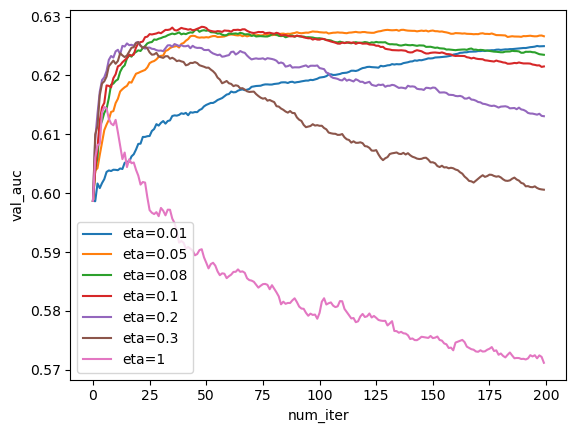

In [19]:
for key, df_scores in scores_eta.items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)
    
plt.show()

**Conclusion**

We can see that most `eta` values reach a peak auc_score of around 0.628. The best is eta=0.1 (auc_score = 0.628275).

This peak is reached after 48 iterations. The next best 

### What's the best max depth of the decision trees?

In [51]:
num_boost_round = 200

eta = 0.1
max_depth_to_test = [3,4,5,6,8,12,20]

scores_max_depth = {}

for m_depth in tqdm(max_depth_to_test):
    xgb_params = {
        'booster': 'gbtree', # default
        'verbosity': 1, # default
        'nthread': 6, # how many cores/ how much parallelization, depends on your system
    
        'eta': eta, 
        'max_depth': m_depth,
        'min_child_weight': 1, # default
    
        'objective' :'binary:logistic', 
        'seed': 1, # random number seed to make the results reproducible
        'eval_metric': 'auc'
    }

    key = f'max_depth={m_depth}'
    scores_max_depth[key] = train_and_evaluate(xgb_params, num_boost_round)

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-auc:0.58169	val-auc:0.58651
[1]	train-auc:0.59528	val-auc:0.60087
[2]	train-auc:0.59294	val-auc:0.59803
[3]	train-auc:0.59397	val-auc:0.60120
[4]	train-auc:0.59827	val-auc:0.60498
[5]	train-auc:0.59833	val-auc:0.60494
[6]	train-auc:0.59861	val-auc:0.60532
[7]	train-auc:0.59879	val-auc:0.60543
[8]	train-auc:0.60062	val-auc:0.60716
[9]	train-auc:0.60186	val-auc:0.60848
[10]	train-auc:0.60323	val-auc:0.60975
[11]	train-auc:0.60435	val-auc:0.61066
[12]	train-auc:0.60426	val-auc:0.61069
[13]	train-auc:0.60515	val-auc:0.61124
[14]	train-auc:0.60765	val-auc:0.61144
[15]	train-auc:0.60866	val-auc:0.61250
[16]	train-auc:0.60968	val-auc:0.61334
[17]	train-auc:0.60979	val-auc:0.61367
[18]	train-auc:0.61149	val-auc:0.61538
[19]	train-auc:0.61204	val-auc:0.61604
[20]	train-auc:0.61319	val-auc:0.61664
[21]	train-auc:0.61407	val-auc:0.61690
[22]	train-auc:0.61534	val-auc:0.61795
[23]	train-auc:0.61609	val-auc:0.61903
[24]	train-auc:0.61640	val-auc:0.61947
[25]	train-auc:0.61705	val-auc:0.61

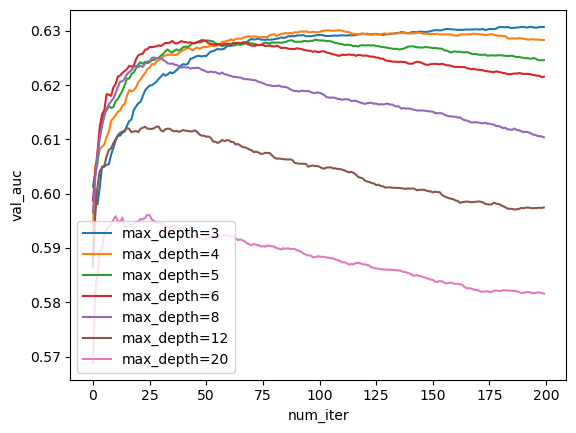

In [28]:
for key, df_scores in scores_max_depth.items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)
    
plt.show()

In [29]:
scores_max_depth.keys()

dict_keys(['max_depth=3', 'max_depth=4', 'max_depth=5', 'max_depth=6', 'max_depth=8', 'max_depth=12', 'max_depth=20'])

In [30]:
scores_max_depth['max_depth=4'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
108,108,0.663554,0.630089
109,109,0.663831,0.630080


In [31]:
scores_max_depth['max_depth=6'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
48,48,0.680429,0.628275
49,49,0.681116,0.628228


In [32]:
scores_max_depth['max_depth=5'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
98,98,0.683362,0.628347
99,99,0.683665,0.628291


**Conclusion**

Setting a `max_depth=4` provides a score of `0.630089` but after 108 iterations.  If we set `'max_depth=6` we achieve a score of 0.628275 after 48. 

The advice from the lectures is to choose a model that doesn't need too many iterations while still having good performance. We should prefer a higher peak at lower iterations. Taking this advice, I'll choose `max_depth=6`.

### What's the minimum child weight we should use?

`min_child_weight` is similar to `min_leaf_node` in RandomForest but it does not specify a minimum number of observations but the minimum “sum of weights” of observations. Higher values are associated with less overfitting. 

In [39]:
num_boost_round = 200

eta = 0.1
max_depth = 6
min_child_weight_to_test = [1,2,3,4,5,10,20,50]

scores_min_child_weight = {}

for min_child in tqdm(min_child_weight_to_test):
    xgb_params = {
        'booster': 'gbtree', # default
        'verbosity': 1, # default
        'nthread': 6, # how many cores/ how much parallelization, depends on your system
    
        'eta': eta, 
        'max_depth': max_depth,
        'min_child_weight': min_child,
    
        'objective' :'binary:logistic', 
        'seed': 1, # random number seed to make the results reproducible
        'eval_metric': 'auc'
    }

    key = f'min_child_weight={min_child}'
    scores_min_child_weight[key] = train_and_evaluate(xgb_params, num_boost_round)

  0%|          | 0/8 [00:00<?, ?it/s]

[0]	train-auc:0.60997	val-auc:0.59872
[1]	train-auc:0.61228	val-auc:0.60394
[2]	train-auc:0.61619	val-auc:0.60772
[3]	train-auc:0.62109	val-auc:0.61230
[4]	train-auc:0.62401	val-auc:0.61460
[5]	train-auc:0.62518	val-auc:0.61535
[6]	train-auc:0.62832	val-auc:0.61831
[7]	train-auc:0.63051	val-auc:0.61824
[8]	train-auc:0.63111	val-auc:0.61799
[9]	train-auc:0.63219	val-auc:0.61954
[10]	train-auc:0.63349	val-auc:0.62020
[11]	train-auc:0.63676	val-auc:0.62155
[12]	train-auc:0.63810	val-auc:0.62175
[13]	train-auc:0.63946	val-auc:0.62225
[14]	train-auc:0.64078	val-auc:0.62259
[15]	train-auc:0.64168	val-auc:0.62294
[16]	train-auc:0.64347	val-auc:0.62354
[17]	train-auc:0.64598	val-auc:0.62337
[18]	train-auc:0.64748	val-auc:0.62356
[19]	train-auc:0.64859	val-auc:0.62476
[20]	train-auc:0.65024	val-auc:0.62547
[21]	train-auc:0.65188	val-auc:0.62567
[22]	train-auc:0.65299	val-auc:0.62577
[23]	train-auc:0.65528	val-auc:0.62651
[24]	train-auc:0.65654	val-auc:0.62660
[25]	train-auc:0.65832	val-auc:0.62

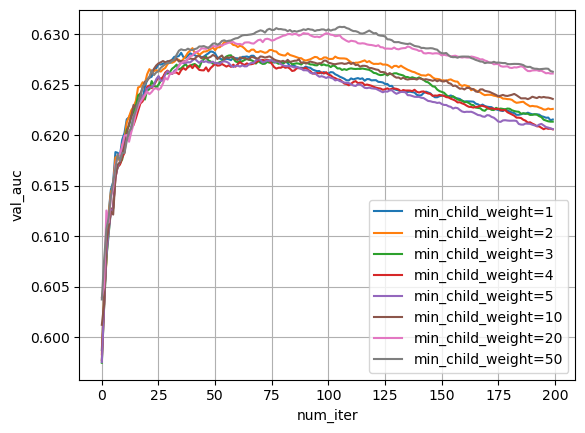

In [40]:
for key, df_scores in scores_min_child_weight.items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)

plt.grid()
plt.show()

In [41]:
scores_min_child_weight['min_child_weight=10'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
49,49,0.665242,0.627926
53,53,0.666984,0.627872


In [42]:
scores_min_child_weight['min_child_weight=5'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
41,41,0.666793,0.627569
69,69,0.683489,0.627500


In [45]:
scores_min_child_weight['min_child_weight=50'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
105,105,0.657685,0.630713
107,107,0.657997,0.630708


In [46]:
scores_min_child_weight['min_child_weight=20'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
89,89,0.671500,0.630087
99,99,0.674313,0.630074


**Conclusion**

It looks like our best `min_child_weight` is quite high i.e. 50. However this occurs after quite a few iterations.

Given the advice, I will opt for min_child_weight=5,

### Evaluating the model with our chosen parameters

- `num_boost_round` = 41
- `eta` = 0.1
- `max_depth` = 6
- `min_child_weight` = 5


In [47]:
num_boost_round_final = 41
eta_final = 0.1
max_depth_final = 6
min_child_weight_final=5

xgb_final_params = {
    'booster': 'gbtree', # default
    'verbosity': 1, # default
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': eta_final, # default
    'max_depth': max_depth_final, 
    'min_child_weight': min_child_weight_final, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

model = xgb.train(xgb_final_params, dtrain, num_boost_round=num_boost_round_final)

y_pred = model.predict(dval)

score = roc_auc_score(y_val, y_pred)
score = np.round(score, 3)
score

np.float64(0.627)

**Observations**

`roc_auc_score`: 0.623

After tuning our model has an roc_auc_score of 0.627. Our base random forest model had an `roc_auc_score` of around 0.623. Our RandomForest model's score was 0.628 after tuning. 

## Final model

I will use the full training set to train a model with the parameters found in the model tuning evaluation above.

In [48]:
# Prepare datasets: `is_severe` still exists in df_full_train so we need to remove it and extract the y_full_train

df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train["is_severe"].values

del df_full_train["is_severe"]

# Create dv and X_full_train and X_test datasets
dicts_full_train = df_full_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False).fit(dicts_full_train)
X_full_train = dv.transform(dicts_full_train)
# additional transforming for XGBoost
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names_out()))

test_dicts = df_test.to_dict(orient="records")
X_test = dv.transform(test_dicts)
# additional transforming for XGBoost
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

num_boost_round_final = 48
eta_final = 0.3
max_depth_final = 4
min_child_weight_final = 1

xgb_final_params = {
    'booster': 'gbtree', # default
    'verbosity': 1, # default
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': eta_final, # default
    'max_depth': max_depth_final, 
    'min_child_weight': min_child_weight_final, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

model = xgb.train(xgb_final_params, dfulltrain, num_boost_round=num_boost_round_final)

y_pred_test = model.predict(dtest)

auc = roc_auc_score(y_test, y_pred_test)
auc

np.float64(0.6283444655932195)

In [49]:
np.round(auc,3) - np.round(score,3)

np.float64(0.0010000000000000009)

### Final model evaluation

Our final model has a slightly higher score (0.628 vs 0.627) than the model we built with the training set alone: the difference is a little greater than 0.001. This is a fraction of a percent so we can say that our model didn't overfit and generalised quite well to unseen data.

That being said, the `roc_auc_score` for this model is quite low. It is slightly better than our logistic regression model and the same as our RandomForest model.